# Exploratory Data Analysis | Team Enron Vizards

### Course: W209 - Section 5
### Author: Akiko Iwamizu

---------------------------------------

## About The Data

Provided by [Kaggle Link](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset), the Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

We conducted basically data preparation and manipulation before beginning EDA. These steps are not included in this notebook, but can be found in our team repo in [GitHub](https://github.com/akikoiwamizu/enron-vizards).

We begin the exploratory data analysis by importing the required libraries and the cleaned dataset.

In [1]:
import altair as alt
import nltk
import pandas as pd
import os
import re
#nltk.download('words')

from ast import literal_eval
from matplotlib import pyplot as plt
from ipywidgets import widgets, interact, interactive, fixed
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
print(os.listdir("../../data"))

['.DS_Store', 'Enron_data_cleansing_colab.ipynb', 'emails_clean.csv', '.ipynb_checkpoints']


In [3]:
df = pd.read_csv("../../data/emails_clean.csv", 
                 converters=
                 {
                     "X-From": literal_eval,
                     "X-To": literal_eval,
                     "X-cc": literal_eval,
                     "X-bcc": literal_eval
                 }
)
df.shape

/var/folders/xb/9fwt2pnd54b42m6d49kws_qm0000gn/T/ipykernel_25006/2170182621.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/emails_clean.csv",


(517092, 21)

After loading in the cleaned dataset, let's take a look at the initial dataframe.

In [4]:
df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,Body,Cc,Bcc,Time,Attendees,Re,day,month,year,time,tzdiff
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,[Phillip K Allen],[Tim Belden],[],[],"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,Here is our forecast\n\n,NaN,NaN,NaN,NaN,NaN,14,5,2001,16:39:00,-700
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,[Phillip K Allen],[John J Lavorato],[],[],"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,Traveling to have a business meeting takes the...,NaN,NaN,NaN,NaN,NaN,4,5,2001,13:51:00,-700
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,[Phillip K Allen],[Leah Van Arsdall],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,test successful. way to go!!!,NaN,NaN,NaN,NaN,NaN,18,10,2000,03:00:00,-700
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,[Phillip K Allen],[Randall L Gay],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN,NaN,NaN,NaN,23,10,2000,06:13:00,-700
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,[Phillip K Allen],[Greg Piper],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,Let's shoot for Tuesday at 11:45.,NaN,NaN,NaN,NaN,NaN,31,8,2000,05:07:00,-700


## Hypothesis 1: 

### Higher volumes of emails were sent at the beginning of the week (Mon-Wed) and in the mornings.

In [5]:
# Create date/time fields that we will need for this viz
df["hour"] = pd.to_datetime(df["time"]).dt.hour.values
df["date_clean"] = pd.to_datetime(df[["year", "month", "day"]])
df["weekday"] = pd.to_datetime(df["date_clean"]).dt.day_name()

In [6]:
# Group the data to get the # of emails sent each weekday/hour. 
# This is necessary for plotting altair with large data sets.
emails_by_weekday = pd.DataFrame({'count': df.groupby(["weekday", "hour"]).size()}).reset_index()
emails_by_weekday.head()

,weekday,hour,count
0,Friday,0,3446
1,Friday,1,5394
2,Friday,2,6276
3,Friday,3,5893
4,Friday,4,5259


In [7]:
%matplotlib inline
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
alt.Chart(emails_by_weekday).mark_bar().encode(
    y = alt.Y("weekday:O", sort=weekday_order, title="Weekday"),
    x = alt.X("hour:O", stack="normalize", title="Hour (PST)"),
    color = alt.Color("count:Q", title="Email Count")
).interactive()

alt.Chart(...)

#### What's informative about this view: 

This view shows the 500,000+ Enron emails sent from 1975-2007. This view is helpful in gaining an overview of the email behaviors during the work week. It shows that higher volumes of emails were sent between the hours of 6:00AM-9:00AM PST. From this chart we can see that emails were sent most often on Wednesdays at 8:00AM PST and began to off around 12PM PST.

#### What could be improved about this view: 

The inclusion of a tooltip so users can interactively hover over the chart and see the actual email counts would be beneficial. Additionally, a way to compare the volumes of emails sent during the work week year over year would be helpful.

---------------------------------------

In [8]:
# Group the data to get the # of emails sent each year/weekday/hour. 
# This is necessary for plotting altair with large data sets.
emails_by_spec = pd.DataFrame({'count': df.groupby(["year", "weekday", "hour"]).size()}).reset_index()
emails_by_spec.head()

,year,weekday,hour,count
0,1979,Monday,16,522
1,1986,Saturday,7,1
2,1986,Thursday,7,1
3,1997,Friday,0,12
4,1997,Friday,1,39


In [9]:
%matplotlib notebook
# Generate a heatmap after calculating the tweet's weekday x hour.
select_year = alt.selection_single(
    name="select", fields=["year"], init={"year": 2001},
    bind=alt.binding_range(min=1997, max=2002, step=1)
)


heatmap = alt.Chart(emails_by_spec).mark_rect(tooltip=True).encode(
    alt.X("weekday:O", sort=weekday_order, title="Weekday"),
    alt.Y("hour:O", title="Hour (PST)"),
    alt.Color("count:Q", title="Email Count"),
).configure_axis(titleFontSize=12,
                  titlePadding=15
).properties(title={"text":"Count of Emails Sent Based on Weekday & Time", 
                    "subtitle":"Use the toggle on the bottom to view a specific year."
                    },
            width=500,
            height=500 
)

heatmap.configure_title(
    fontSize=16,
    font="Helvetica",
    anchor="middle",
    subtitleFontSize=12,
    subtitlePadding=5,
    subtitleFont="Helvetica",
    subtitleFontStyle="italic"
).add_selection(select_year).transform_filter(select_year)

alt.Chart(...)

#### What's informative about this view: 

This view explores when emails were often sent during the work week over the years of data available. It is helpful in highlighting areas with higher email volume and how that changed over time.


#### What could be improved about this view:  

It is difficult to compare years using the toggle. It might be useful to create a matrix of heatmaps by year for easier visual comparison, so the viewer doesn't need to memorize the visualizations.


#### Conclusion: 

These data views suggest that the hypothesis was correct and that higher volumes of emails are in fact sent at the beginning of the work week and at earlier hours of the day.

---------------------------------------

## Hypothesis 2:


### Enron’s human resources employees were among the top 100 people who sent/received the most emails during the period of the scandal.

In [10]:
# Create a subset of the email dataset to only the scandal period
# Defining the scandal period as the date when Bethany McLean publishes an article "Is Enron Overpriced?"
# in Fortune magazine. She writes that investors are generally clueless as to how Enron earns its reported profits.
scandal_period = df[df["date_clean"] >= "2001-03-05"]

# Email authors
authors = pd.Series([item for row in scandal_period["X-From"] for item in row if item])
authors = pd.DataFrame({"name": authors.value_counts().index,
                        "sent": authors.value_counts()}).reset_index(drop=True).sort_values(by="sent", ascending=False)

# Email recipients
all_recipients = scandal_period["X-To"] + scandal_period["X-cc"] + scandal_period["X-bcc"]
recipients = pd.Series([item for row in all_recipients for item in row if item])
recipients = pd.DataFrame({"name": recipients.value_counts().index,
                           "received": recipients.value_counts()}).reset_index(drop=True).sort_values(by="received", ascending=False)


In [11]:
# Standardize all name variations for Enron's legal and human resources teams
james_derrick = ["James Derrick", "Jim Derrick", "Jimi Derrick",]
robert_jones = ["Robert Jones", "Robert.Jones", "Robert W. Jones", "Robert W.- HR Exec", "Enron HR Executive"]

andrew_fastow = authors.name[authors.name.apply(lambda x: "Andrew S Fastow" in x)]
arthur_andersen = authors.name[authors.name.apply(lambda x: "Arthur Andersen" in x)]
jeff_skilling = authors.name[authors.name.apply(lambda x: "Jeff Skilling" in x)]
ken_lay = authors.name[authors.name.apply(lambda x: "Ken Lay" in x)]

james_derrick = authors.name[authors.name.apply(lambda x: any([s in x for s in james_derrick]))]
kristina_mordaunt = authors.name[authors.name.apply(lambda x: "Kristina Mordaunt" in x)]
jordan_mintz = authors.name[authors.name.apply(lambda x: "Jordan Mintz" in x)]
scott_sefton = authors.name[authors.name.apply(lambda x: "Scott Sefton" in x)]
legal_other = authors.name[authors.name.apply(lambda x: "Legal" in x)]

robert_jones = authors.name[authors.name.apply(lambda x: any([s in x for s in robert_jones]))]
cindy_olson = authors.name[authors.name.apply(lambda x: "Cindy Olson" in x)]
david_oxley = authors.name[authors.name.apply(lambda x: "David Oxley" in x)]

In [12]:
# Clean dataset with correct names
def clean_names(name_list):
    for i, name in enumerate(name_list):
        
        # Key players
        if name in andrew_fastow:
            name_list[i] = "Andrew Fastow"
        elif name in arthur_andersen:
            name_list[i] = "Arthur Andersen"
        elif name in jeff_skilling:
            name_list[i] = "Jeff Skilling"
        elif name in ken_lay:
            name_list[i] = "Kenneth Lay"
       
        # Legal team
        elif name in james_derrick:
            name_list[i] = "James Derrick"
        elif name in kristina_mordaunt:
            name_list[i] = "Kristina Mordaunt"
        elif name in jordan_mintz:
            name_list[i] = "Jordan Mintz"
        elif name in scott_sefton:
            name_list[i] = "Scott Sefton"

        # HR team
        elif name in robert_jones:
            name_list[i] = "Robert Jones"
        elif name in cindy_olson:
            name_list[i] = "Cindy Olson"
        elif name in david_oxley:
            name_list[i] = "David Oxley"
        return name_list

scandal_period_clean = scandal_period.copy()
scandal_period_clean["X-From"] = scandal_period_clean["X-From"].apply(lambda x: clean_names(x))
scandal_period_clean["X-To"] = scandal_period_clean["X-To"].apply(lambda x: clean_names(x)) 
scandal_period_clean["X-cc"] = scandal_period_clean["X-cc"].apply(lambda x: clean_names(x)) 
scandal_period_clean["X-bcc"] = scandal_period_clean["X-bcc"].apply(lambda x: clean_names(x))

In [13]:
# Clean hr team employee names
hr_team = ["Robert Jones", "David Oxley", "Cindy Olson"]

# Email authors
authors = pd.Series([item for row in scandal_period_clean["X-From"] for item in row if item])
authors = authors.apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
authors = pd.DataFrame({"name": authors.value_counts().index,
                        "sent": authors.value_counts()}).reset_index(drop=True).sort_values(by="sent", ascending=False)

# Email recipients
all_recipients = scandal_period_clean["X-To"] + scandal_period_clean["X-cc"] + scandal_period_clean["X-bcc"]
recipients = pd.Series([item for row in all_recipients for item in row if item])
recipients = recipients.apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
recipients = pd.DataFrame({"name": recipients.value_counts().index,
                           "received": recipients.value_counts()}).reset_index(drop=True).sort_values(by="received", ascending=False)

# Merge both dataframes
emails = pd.merge(authors, recipients, how="outer", on="name").fillna(0)
emails["total"] = emails["sent"] + emails["received"]
emails = emails.sort_values(by="total", ascending=False)[:300].reset_index(drop=True)
emails["is_human_resources"] = emails["name"].apply(lambda x: True if x in hr_team else False)


In [14]:
%matplotlib inline
alt.Chart(emails, title="Top 300 Enron Emails Recipients During the Scandal Period (After March 3rd, 2001)").mark_bar(tooltip=True).encode(
    x=alt.X("total:Q", title="Total Emails Sent/Received"),
    y=alt.Y("name:N", sort="-x", title="Employee Name"),
    color=alt.Color("is_human_resources", title="HR Employee")
)


alt.Chart(...)

In [15]:
emails_new = emails.reset_index()
emails_new["rank"] = (emails_new["index"] + 1).astype(int)
emails_new["name"] = emails_new["rank"].astype(str) + " - " + emails_new["name"]

frames = [emails_new[emails_new["index"] < 10],
          pd.DataFrame({"index":"...","name":"...","sent":0,"received":0,"total":0,"is_human_resources":False,"rank":11},index=[11]),
          emails_new[emails_new["rank"] > 289]
         ]

email_people_hr = pd.concat(frames)


In [16]:
emails_new.head()

,index,name,sent,received,total,is_human_resources,rank
0,0,1 - Pete Davis,2966.0,13725.0,16691.0,False,1
1,1,2 - Jeff Dasovich,6308.0,7444.0,13752.0,False,2
2,2,3 - Kay Mann,6032.0,3791.0,9823.0,False,3
3,3,4 - Richard Shapiro,692.0,8634.0,9326.0,False,4
4,4,5 - Vince J Kaminski,4124.0,3336.0,7460.0,False,5


In [17]:
%matplotlib inline
alt.Chart(email_people_hr, title="Top 300 Enron Emails Recipients During the Scandal Period (After March 3rd, 2001)").mark_bar(tooltip=True).encode(
    x=alt.X("total:Q", title="Total Emails Sent/Received"),
    y=alt.Y("name:N", sort=alt.EncodingSortField(field="rank", order="ascending"), title="Employee Name"),
    color=alt.Color("is_human_resources", title="HR Employee")
).properties(width=600)


alt.Chart(...)

#### Conclusion: 

These data views suggest that the hypothesis was incorrect. Although the HR Executive Director, David Oxley, was ranked 297 out of 300 of the employees with the highest total emails sent/received during the scandal period, they were not in the top 100 ranking. There was no direct relationship shown between emails sent/received to human resources during the scandal.

---------------------------------------

## Hypothesis 3:

### The most common words in the email messages from key players of the scandal were greetings or meeting dates/times.

In [18]:
# Email authors + their messages
email_messages = df[["From", "X-From", "Body"]]
email_messages.head()

,From,X-From,Body
0,phillip.allen@enron.com,[Phillip K Allen],Here is our forecast\n\n
1,phillip.allen@enron.com,[Phillip K Allen],Traveling to have a business meeting takes the...
2,phillip.allen@enron.com,[Phillip K Allen],test successful. way to go!!!
3,phillip.allen@enron.com,[Phillip K Allen],"Randy,\n\n Can you send me a schedule of the s..."
4,phillip.allen@enron.com,[Phillip K Allen],Let's shoot for Tuesday at 11:45.


To explore this question, let's first create a subset of the email data to include only the key players of the scandal. First, we will likely need to clean up the "From" field in the dataset.

In [19]:
# Clean up "From" field
email_messages["Name"] = email_messages["X-From"].str[0]
email_messages["Name"] = email_messages["Name"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())


In [20]:
# Create a subset of email messages from key players in the scandal
key_players = ["Andrew Fastow", "Jeff Skilling", "Kenneth Lay", "Sherron Watkins"]
email_messages_kp = email_messages.loc[email_messages["Name"].isin(key_players)]
email_messages_kp.head()


,From,X-From,Body,Name
19056,kenneth.lay@enron.com,[Kenneth Lay],\n\nTo:\tAssociate/Analyst Program Worldwide\...,Kenneth Lay
19850,kenneth.lay@enron.com,[Kenneth Lay],\n\nTo:\tAssociate/Analyst Program Worldwide\...,Kenneth Lay
32819,40enron@enron.com,[Jeff Skilling@ENRON],Dear Enron Employees:\n\nI am saddened to info...,Jeff Skilling
38254,sherron.watkins@enron.com,[Sherron Watkins],\n\tIn August we were discussing the additiona...,Sherron Watkins
38257,sherron.watkins@enron.com,[Sherron Watkins],Take a look at these pics! For anyone who has ...,Sherron Watkins


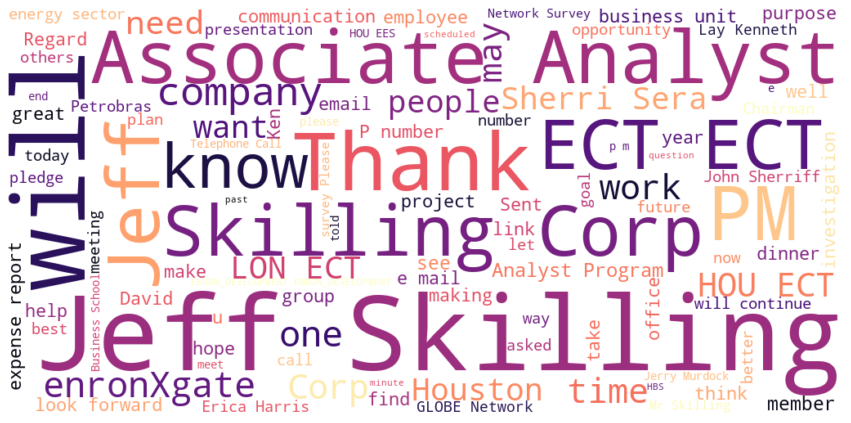

<Figure size 432x288 with 0 Axes>

In [21]:
%matplotlib inline
text = " ".join(item for item in email_messages_kp["Body"])

stopwords = set(STOPWORDS)
stopwords.update(["cc", "Subject", "Re", "Enron", "NA", "ENRON", "Original", "Message", "IMAGE"])

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white", 
                      max_words=100,
                      width=1024, 
                      height=500,
                      colormap="magma"                      
                     ).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
plt.savefig("cloud_key_players.png")

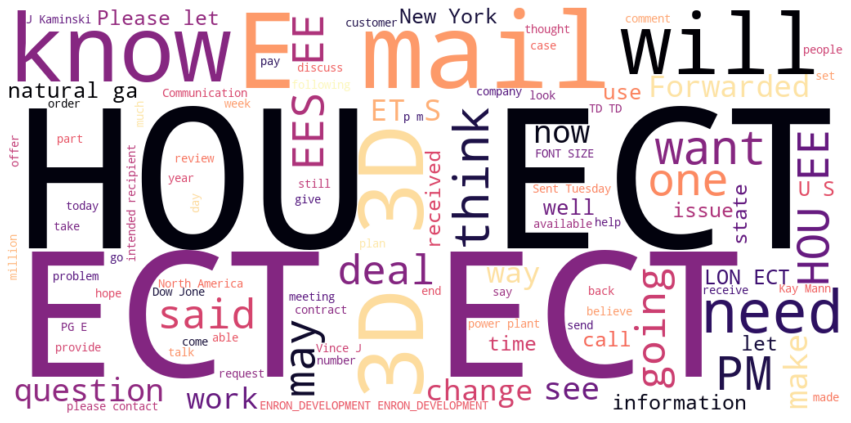

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline
text = " ".join(item for item in email_messages["Body"])

stopwords = set(STOPWORDS)
stopwords.update(["cc", "Subject", "Re", "Enron", "NA", "ENRON", "Original", "Message", "IMAGE"])

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white", 
                      max_words=100,
                      width=1024, 
                      height=500,
                      colormap="magma"                      
                     ).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
plt.savefig("cloud_all.png")

To improve the visualization, let's allow users to interactively select the key players in the scandal and see how their word clouds change.

In [23]:
%matplotlib notebook
def clean_emails(Employee, frame, col):
    newframe=frame.copy()  
    newframe[col] = newframe[col].str.replace('\d+', "", regex=True).str.replace("?", "", regex=True).str.replace('\W', " ", regex=True).str.lower()
    newframe = newframe[newframe["Name"]==Employee].astype(str)
    
    text = " ".join(newframe[col][:])
    pattern = re.compile(r'\b(' + r'|'.join(set(STOPWORDS)) + r')\b\s*')
    cleantext = pattern.sub("", text)
    
    text_tokenized = cleantext.split(" ")
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text_tokenized if word != ""]
    cloudtext = " ".join(words)
    
    return cloudtext

def make_clouds(Employee, frame, col, Maximum, title):
    cloudtext = clean_emails(Employee, frame, col)
    wordcloud = WordCloud(max_font_size=40, max_words=Maximum, background_color="white", collocations=False).generate(cloudtext)
    wordcloud.generate_from_frequencies
    
    plt.style.use("tableau-colorblind10")
    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=18, fontweight="bold")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
cloud = interact(make_clouds, 
         Employee=key_players,
         Maximum=[100, 75, 50, 25],
         df=fixed(email_messages_kp), 
         col=fixed("Body"), 
         title=fixed("\nMost Common Words in Emails by the Enron Scandal Key Players\n"),
         frame=fixed(email_messages_kp[["Name","Body"]])
        )


interactive(children=(Dropdown(description='Employee', options=('Andrew Fastow', 'Jeff Skilling', 'Kenneth Lay…

#### Conclusion: 

These data views suggest that the most common words used by key players in their emails vary quite a bit depending on the employee. Across all the key players, there are various greetings and meeting times like the key player's names and "Monday" or "pm" likely for scheduling purposes, but there are also many common words like "enronxgate", "investigation", and various references to internal initiatives like the petrobas gas initiative. 

---------------------------------------